# Load packages

In [24]:
%load_ext autoreload
%autoreload 2

import importlib

# custom packages
from src.gym2048 import gym2048
from src.models import CNN22
from src.RL import TDL

importlib.reload(importlib.import_module('src.gym2048'))
importlib.reload(importlib.import_module('src.RL'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import cProfile
import pstats

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and test environment

In [9]:
env = gym2048()

In [10]:
env.check()


 Check SwipeLeft 

[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True

 Check SwipeLeft 

[[0 0 2 2]
 [0 2 2 2]
 [2 0 2 0]
 [0 2 0 0]]
[[4 0 0 0]
 [4 2 0 0]
 [4 0 0 0]
 [2 0 0 0]]
[[0 0 0 4]
 [0 0 2 4]
 [0 0 0 4]
 [0 0 0 2]]
[[2 4 4 4]
 [0 0 2 0]
 [0 0 0 0]
 [0 0 0 0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [2 4 4 4]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]

 Check encode 

/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:54: UserWarning: It seems that your observation  is an image but its `dtype` is (float32) whereas it has to be `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:62: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/preprocessing.py:23: UserWarning: Treating image space as channels-last, while second dimension was smallest of the three.
  warnings.warn("Treating image space as channels-last, while second dimension was smallest of the three.")
/opt/homebrew/lib/python3.10/

# TD-learning

In [9]:
#env = Monitor(env, filename="./logs/tdl_cnn_2024_11_14_1.csv")
model = TDL(CNN22, env, device="mps")
#model.load_network('./TDL_CNN_2024_11_10_1/rl_model_10000_epsiodes.zip')

In [ ]:
#profiler = cProfile.Profile()
#profiler.enable()

model.learn(
    1e7, 
    learning_rate=1e-3, 
    gamma=0.99, 
    buffer_size=100000, 
    exploration_initial_eps=0.0, 
    exploration_final_eps=0.0, 
    exploration_fraction=0.1, 
    train_freq=1024, 
    batch_size=1024, 
    target_network_update_freq=-1, # -1 for no target network 
    prioritized_replay=True, 
    prioritized_replay_alpha=0.6, 
    prioritized_replay_beta0=0.4, 
    prioritized_replay_beta_increment=1e-4, 
    prioritized_replay_eps=1e-6,
    prioritized_replay_update_freq=500, 
    checkpoint_path='./exp/TDL_CNN_2024_11_17/', 
    checkpoint_freq=2500, 
    check_gradient_freq=500, 
    restart_jump=True, 
    use_symmetry=True
    )

#profiler.disable()
#stats = pstats.Stats(profiler)

KeyboardInterrupt: 

In [25]:
profiler = cProfile.Profile()
profiler.enable()

env = gym2048()
model = TDL(CNN22, env)
model.load_network('./exp/TDL_CNN_2024_11_16/rl_model_10000_epsiodes.zip')

model.eval()

model.env.playOneGame(model=model, verbose=True)

profiler.disable()
stats = pstats.Stats(profiler)
stats.dump_stats('./profile_results.prof')

Final state:
[[   2    8 4096    4]
 [   4  128   64 1024]
 [   8  256    2  512]
 [   2    4   16    8]]
Max tile: 4096
Score: 60288
Number of moves: 2801


In [13]:
def get_param_stats(model):
    stats = {
        "Layer": [],
        "Min": [],
        "Max": [],
        "Mean": [],
        "Std": [],
        "Num Params": []
    }

    for name, param in model.named_parameters():
        if param.requires_grad:
            stats["Layer"].append(name)
            stats["Min"].append(param.data.min().item())
            stats["Max"].append(param.data.max().item())
            stats["Mean"].append(param.data.mean().item())
            stats["Std"].append(param.data.std().item())
            stats["Num Params"].append(param.numel())

    # Convert to DataFrame for easy viewing
    stats_df = pd.DataFrame(stats)
    return stats_df

# Example usage
model_stats = get_param_stats(model.policy_network)
print(model_stats)

          Layer       Min       Max      Mean       Std  Num Params
0  cnn.0.weight -0.625971  0.523045 -0.027293  0.130198       14336
1    cnn.0.bias -0.135434  0.080847 -0.040366  0.032864         256
2  cnn.2.weight -0.775088  0.873375 -0.005078  0.120528      524288
3    cnn.2.bias -0.145905  0.150085 -0.013121  0.044585         512
4   fc.0.weight -1.199935  0.950004  0.000125  0.107282     2097152
5     fc.0.bias -0.146495  0.209030  0.040163  0.074993        1024
6   fc.2.weight -1.189375  1.106125  0.001440  0.101078      262144
7     fc.2.bias -0.207094  0.276019  0.085669  0.110049         256
8   fc.4.weight -0.200603  0.256053  0.018344  0.110356         256
9     fc.4.bias  0.178388  0.178388  0.178388       NaN           1


In [ ]:

model_max_tiles, model_n_steps = env.evaluate(model=model, n_games=1000)

data = {
    'max_tiles': model_max_tiles,
    'n_steps': model_n_steps
    }

with open('./exp/TDL_CNN_2024_11_16/stats_10000_epsiodes.pkl', 'wb') as file:
    pickle.dump(data, file)

100%|██████████| 1000/1000 [26:47<00:00,  1.61s/it]


# Comparison

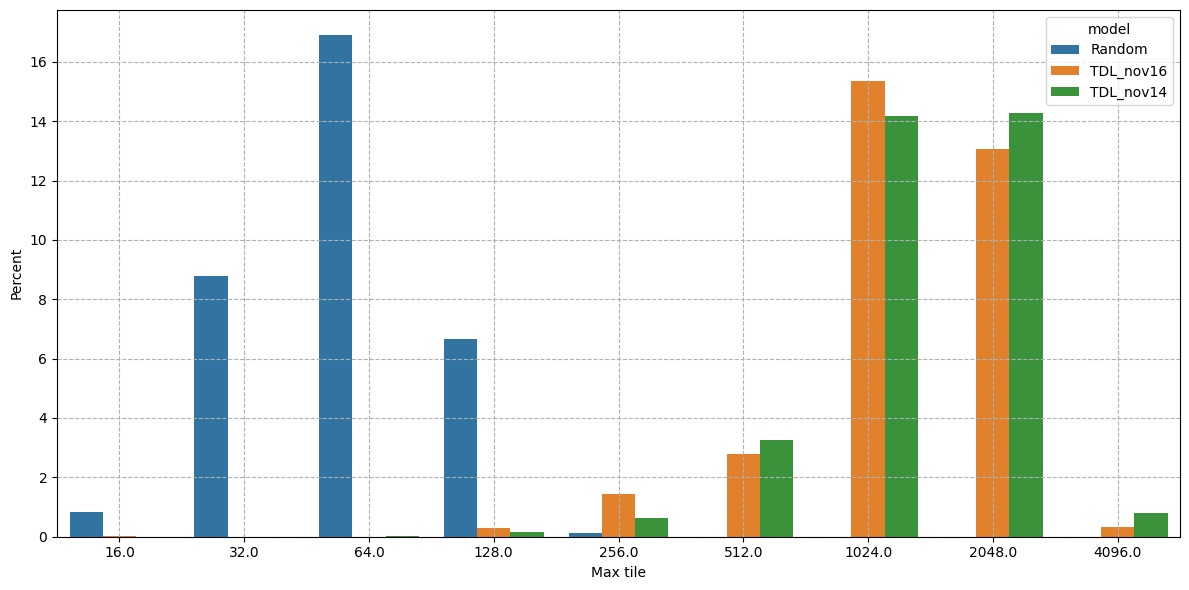

In [28]:
models = {
    'Random': './exp/2048_random.pkl',
    'TDL_nov14': './exp/TDL_CNN_2024_11_14_1/stats_10000_episodes.pkl',
    'TDL_nov16': './exp/TDL_CNN_2024_11_16/stats_10000_episodes.pkl'
}

df = pd.DataFrame()

for id, path in models.items():
    with open(path, 'rb') as file:
        data = pickle.load(file)
    df_loc = pd.DataFrame({'max_tiles':data['max_tiles']})
    df_loc['model'] = id
    df = pd.concat([df, df_loc], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.countplot(df, x="max_tiles", hue="model", stat="percent")
plt.xlabel('Max tile')
plt.ylabel('Percent')
plt.tight_layout()
plt.grid(linestyle='--')
plt.show()